In this notebook we will be building and training LSTM to predict IBM stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable




## 2. Load data

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("../input/Data/Stocks/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

In [3]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)
df.drop(columns=df.columns.difference(['Close']), inplace=True)
df.fillna(method='pad')
df

/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_19825/2938606158.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad')


,Close
timestamp,
2022-01-01 04:00:00,172.930
2022-01-01 05:00:00,171.470
2022-01-01 06:00:00,173.220
2022-01-01 07:00:00,172.470
2022-01-01 08:00:00,173.160
...,...
2023-12-31 02:00:00,101.411
2023-12-31 03:00:00,100.738
2023-12-31 04:00:00,100.743


In [4]:
df.head()

,Close
timestamp,
2022-01-01 04:00:00,172.93
2022-01-01 05:00:00,171.47
2022-01-01 06:00:00,173.22
2022-01-01 07:00:00,172.47
2022-01-01 08:00:00,173.16


In [5]:
df_sol=df[['Close']]
df_sol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17499 entries, 2022-01-01 04:00:00 to 2023-12-31 06:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   17499 non-null  float64
dtypes: float64(1)
memory usage: 273.4 KB


In [6]:
df_sol=df_sol.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_sol['Close'] = scaler.fit_transform(df_sol['Close'].values.reshape(-1,1))
#df_ibm

/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_19825/2689664548.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sol=df_sol.fillna(method='ffill')


In [7]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_sol, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (13951, 59, 1)
y_train.shape =  (13951, 1)
x_test.shape =  (3488, 59, 1)
y_test.shape =  (3488, 1)


In [9]:
print('x_train.shape = ',x_train.dtype)
print('y_train.shape = ',y_train.dtype)
print('x_test.shape = ',x_test.dtype)
print('y_test.shape = ',y_test.dtype)

x_train.shape =  float64
y_train.shape =  float64
x_test.shape =  float64
y_test.shape =  float64


In [37]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [10]:
y_test

array([[-0.82700741],
       [-0.82698399],
       [-0.82596528],
       ...,
       [ 0.0830245 ],
       [ 0.08308305],
       [ 0.09749715]])

In [15]:
y_train.size(),x_train.size()

(torch.Size([13951, 1]), torch.Size([13951, 59, 1]))

## 3. Build the structure of model

In [16]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [11]:
look_back-1

59

In [18]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    # if t % 10 == 0 and t !=0:
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  0 MSE:  0.14642484486103058
Epoch  1 MSE:  0.21629904210567474
Epoch  2 MSE:  0.13370008766651154
Epoch  3 MSE:  0.12062379717826843
Epoch  4 MSE:  0.12625965476036072
Epoch  5 MSE:  0.1275855153799057
Epoch  6 MSE:  0.11958354711532593
Epoch  7 MSE:  0.10170003771781921
Epoch  8 MSE:  0.07612790912389755
Epoch  9 MSE:  0.05207287147641182
Epoch  10 MSE:  0.04895942285656929
Epoch  11 MSE:  0.04434112459421158
Epoch  12 MSE:  0.014506455510854721
Epoch  13 MSE:  0.0094843665137887
Epoch  14 MSE:  0.026623552665114403
Epoch  15 MSE:  0.02880322001874447
Epoch  16 MSE:  0.01873287558555603
Epoch  17 MSE:  0.008283215574920177
Epoch  18 MSE:  0.004343805368989706
Epoch  19 MSE:  0.008555678650736809
Epoch  20 MSE:  0.013980218209326267
Epoch  21 MSE:  0.01328964065760374
Epoch  22 MSE:  0.008799939416348934
Epoch  23 MSE:  0.0059342836029827595
Epoch  24 MSE:  0.005804710555821657
Epoch  25 MSE:  0.00648298766463995
Epoch  26 MSE:  0.00628210324794054
Epoch  27 MSE:  0.005089716520

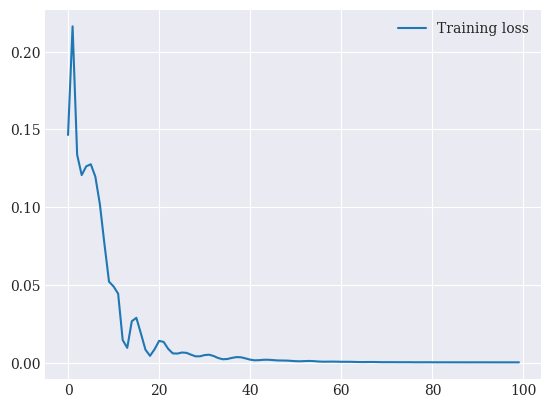

In [19]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [22]:
np.shape(y_train_pred)
# y_train_pred

torch.Size([13951, 1])

In [23]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.10 RMSE
Test Score: 1.07 RMSE


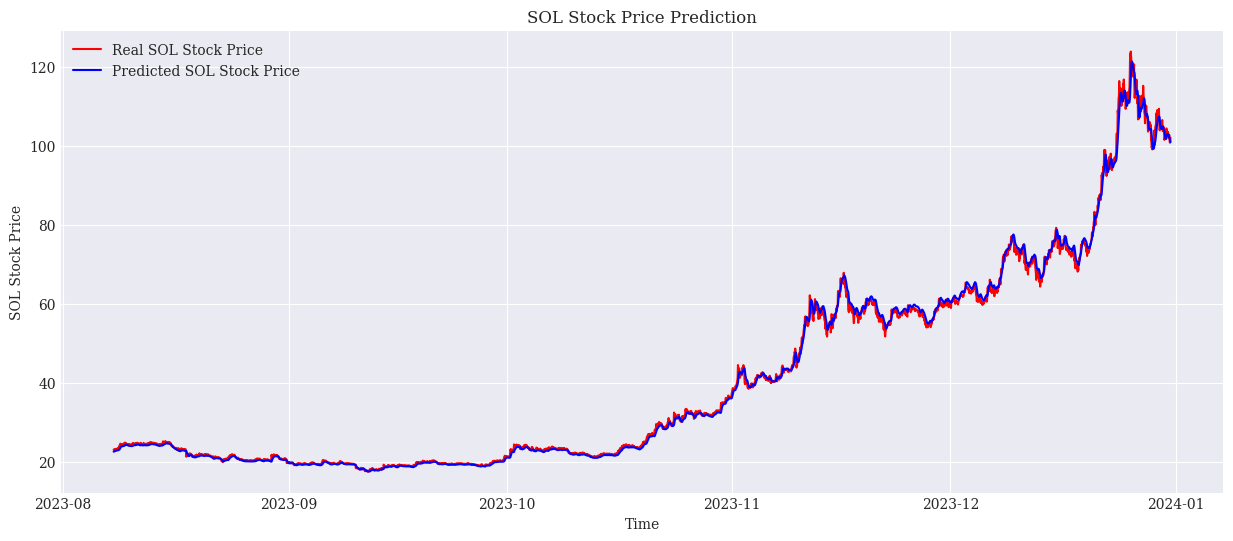

In [24]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_sol[len(df_sol)-len(y_test):].index, y_test, color = 'red', label = 'Real SOL Stock Price')
axes.plot(df_sol[len(df_sol)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted SOL Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('SOL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SOL Stock Price')
plt.legend()
# plt.savefig('ibm_pred.png')
plt.show()